# Capstone Notebook v2

In [1]:
import numpy as np; import pandas as pd ; import json
from geopy.geocoders import Nominatim; import requests
from pandas.io.json import json_normalize; import foursquare

### Get geospatial data

In [2]:
address = 'Atlanta, GA'

geolocator = Nominatim(user_agent="atl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Atlanta are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Atlanta are 33.7490987, -84.3901849.


### Define Foursquare API credentials and get results

In [3]:
CLIENT_ID = 'PKGNYCMU0KCBLQRPB5X1RH4EO3K4IDXVZ4QHQ1AVJFQ1AQ5G' # your Foursquare ID
CLIENT_SECRET = 'LYTUHFXEFHNJCHO3PZ2JCCTWWDFVC2UCKEJFEWQKL0LZKKQ5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 2000

# Foursqaure URL 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url
results = requests.get(url).json()

### Turn data into a dataframe

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = \
    nearby_venues.apply(get_category_type, axis=1) #filter the category for each row
nearby_venues.columns = \
    [col.split(".")[-1] for col in nearby_venues.columns] #change column headers

<ipython-input-4-c613c4ab3fdb>:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


In [5]:
nearby_venues.head()

,name,id,categories,lat,lng
0,The Masquerade,40e0b100f964a520e9061fe3,Music Venue,33.751720,-84.389739
1,Jamrock Restaurant,4c40e04eaf052d7f16817c79,Caribbean Restaurant,33.751554,-84.391356
2,Ebrik Coffee Room,5303ba1a498e8936e10f0c4a,Coffee Shop,33.753897,-84.388782
3,Fish Bowl Poké,57d42371498ebd10aa19e10b,Poke Place,33.755727,-84.389400
4,Wine Shoe,4b0dd396f964a520de5023e3,Wine Shop,33.751559,-84.398937


## Data pre-processing

In [6]:
nearby_venues['categories'].unique()

array(['Music Venue', 'Caribbean Restaurant', 'Coffee Shop', 'Poke Place',
       'Wine Shop', 'Deli / Bodega', 'Pharmacy',
       'College Basketball Court', 'Korean Restaurant', 'Hookah Bar',
       'Gym', 'Vietnamese Restaurant', 'Burger Joint', 'Greek Restaurant',
       'Dive Bar', 'Basketball Stadium', 'Art Gallery', 'Farmers Market',
       'Mexican Restaurant', 'Sushi Restaurant', 'Football Stadium',
       'Historic Site', 'Outdoor Sculpture', 'Fast Food Restaurant',
       'Performing Arts Venue', 'Moving Target', 'Sports Club',
       'Juice Bar', 'BBQ Joint', 'Strip Club', 'Park',
       'Mediterranean Restaurant', 'Arepa Restaurant',
       'Latin American Restaurant', 'Museum', 'English Restaurant',
       'Neighborhood', 'Café', 'Indian Restaurant', 'Bar', 'Pizza Place',
       'Sports Bar', 'Fountain', 'Tea Room', 'Theater',
       'Convention Center', 'Cajun / Creole Restaurant',
       'American Restaurant', 'Candy Store', 'Cemetery',
       'Seafood Restaurant', 'Hot

### Filter dataframe to only include restaurants and bars

In [7]:
venues_df = nearby_venues
venues_df = venues_df.drop([0,2,4,6,7,10,14,15,18,22,23,24,
                                26,28,29,30,31,34,37,39,41,42,46,
                                47,48,49,52,53,58,59,61,62,63,
                                66,68,70,71,74,75,76,78,79,85,89,
                                90,93,98,69,77,97]) 
venues_df.reset_index(drop=True,inplace=True)
venues_df = venues_df.drop(['lat','lng'], axis=1) #drop latitude and longitude columns
venues_df.head()

,name,id,categories
0,Jamrock Restaurant,4c40e04eaf052d7f16817c79,Caribbean Restaurant
1,Fish Bowl Poké,57d42371498ebd10aa19e10b,Poke Place
2,Reuben's Deli,4a89913bf964a5206d0820e3,Deli / Bodega
3,Blossom Tree,4d920f119d0f721e6b692473,Korean Restaurant
4,Anatolia Cafe & Hookah Lounge,4b6315eaf964a520e8612ae3,Hookah Bar


### Add new columns describing each restaurants, to use for feature sets in clustering

Use the Python Foursquare package

In [8]:
client = foursquare.Foursquare(client_id='PKGNYCMU0KCBLQRPB5X1RH4EO3K4IDXVZ4QHQ1AVJFQ1AQ5G', 
                               client_secret='LYTUHFXEFHNJCHO3PZ2JCCTWWDFVC2UCKEJFEWQKL0LZKKQ5')

# Get likes, ratings, tips, and photos data of each venue 
like_list = []
for i in venues_df['id']:
    likes_dict = client.venues.likes(i)
    like_list.append(likes_dict['likes']['count'])

ratings_list = []
for i in venues_df['id']:
    ratings_dict = client.venues(i)
    ratings_list.append(ratings_dict['venue']['rating'])
    
photos_list = []
for i in venues_df['id']:
    photos_dict = client.venues(i)
    photos_list.append(photos_dict['venue']['photos']['count'])


Add new data columns to dataframe

In [18]:
venues_df['rating'] = ratings_list
venues_df['likes'] = like_list
venues_df['photos'] = photos_list

venues_df.head()

,name,id,categories,rating,likes,photos
0,Jamrock Restaurant,4c40e04eaf052d7f16817c79,Caribbean Restaurant,8.0,19,14
1,Fish Bowl Poké,57d42371498ebd10aa19e10b,Poke Place,8.7,24,11
2,Reuben's Deli,4a89913bf964a5206d0820e3,Deli / Bodega,8.6,58,66
3,Blossom Tree,4d920f119d0f721e6b692473,Korean Restaurant,8.4,57,62
4,Anatolia Cafe & Hookah Lounge,4b6315eaf964a520e8612ae3,Hookah Bar,8.3,146,194


## Exploratory Data Analysis 

The relationship betweeen likes and rating:

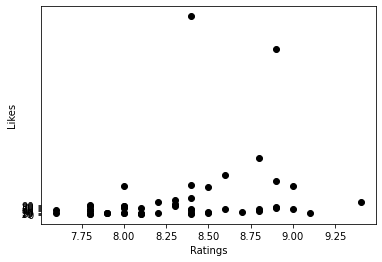

In [32]:
import matplotlib.pyplot 
df1 = venues_df[['rating','likes']]

# Visualize data with a scatterplot
plt.scatter(df1["rating"],df1["likes"],c='black')
plt.xlabel('Ratings')
plt.ylabel('Likes')
plt.yticks(np.arange(0, 100, 10))
plt.show()

The relationship between number of photos and rating:

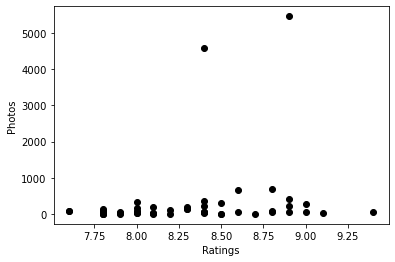

In [26]:
df2 = venues_df[['rating','photos']]

# Visualize data with a scatterplot
plt.scatter(df2["rating"],df2["photos"],c='black')
plt.xlabel('Ratings')
plt.ylabel('Photos')
plt.show()

For both variables photos and likes, there doesn't seem to be a clear relationship with rating.

## Clustering

In [27]:
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
print('Packages imported')

Packages imported


C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [34]:
from sklearn.preprocessing import StandardScaler
venues_df = venues_df.drop(['name','id','categories'], axis=1)
norm_venues = StandardScaler().fit_transform(venues_df)
norm_venues

array([[-7.50429859e-01, -4.02341769e-01, -3.09804226e-01],
       [ 8.80939400e-01, -3.88242324e-01, -3.12871595e-01],
       [ 6.47886649e-01, -2.92366096e-01, -2.56636504e-01],
       [ 1.81781146e-01, -2.95185985e-01, -2.60726329e-01],
       [-5.12716053e-02, -4.42158602e-02, -1.25762112e-01],
       [-5.12716053e-02, -1.54191533e-01, -1.81997202e-01],
       [-5.17377108e-01, -4.33360549e-01, -3.22073700e-01],
       [ 1.34704490e+00, -2.35968315e-01, -2.56636504e-01],
       [ 1.34704490e+00,  4.16587849e+00,  5.26667184e+00],
       [ 1.81781146e-01, -4.24900881e-01, -3.06736857e-01],
       [ 1.58009765e+00,  3.30829383e-01, -3.98757915e-02],
       [ 4.14833897e-01, -3.88242324e-01, -3.12871595e-01],
       [-5.17377108e-01, -4.07981547e-01, -3.01624576e-01],
       [ 1.58009765e+00, -2.98005874e-01, -2.62771241e-01],
       [-5.17377108e-01, -2.75446762e-01, -1.18604918e-01],
       [ 1.81781146e-01,  9.36203163e-03, -1.02245619e-01],
       [-1.21653536e+00, -1.76750645e-01

In [37]:
num_clusters = 2

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(norm_venues)
labels = k_means.labels_
print(labels)

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0]
